# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

Далее будет в основном описан ход работы, а в конце отчёт

Импортируем библиотеки и скачаем необходимые модули для корректной работы API

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import datetime
import re
import unicodedata
import fastai
from fastai import *
from fastai.text import * 
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from fastai.text.all import *
import seaborn as sns

Считаем датасет

In [7]:
df = pd.read_csv("data/parsed_reviews3.csv")
df["date"] = pd.to_datetime(df["date"])
print(df.head())
print(df.dtypes)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      body  \
0  &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пишу сюда для более скорого разрешения вопроса &lt;/p&gt;\r\n&lt;p&gt;Пополнил через Юмани Озон банк&lt;/p&gt;\r\n&lt;p&gt;после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться)&lt;/p&gt;\r\n&lt;p&gt;просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю&lt;/p&gt;\

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/artur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Найдём топ 15 банков по числу отзывов

In [9]:
top15_review_count = df.groupby(['bank_name'])["bank_name"].count().sort_values(ascending=False)[0:15]
print(top15_review_count)

bank_name
Тинькофф Банк                              44864
Хоум Кредит Банк                            9310
Совкомбанк                                  6111
ВТБ                                         3817
СберБанк                                    3490
Альфа-Банк                                  3369
Россельхозбанк                              3064
Банк Открытие                               1894
МТС Банк                                    1542
Модульбанк                                  1460
Газпромбанк                                 1314
Московский Кредитный Банк                   1251
Азиатско-Тихоокеанский Банк                 1001
Уральский Банк Реконструкции и Развития      748
Русский Стандарт                             689
Name: bank_name, dtype: int64


Найдём какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг

In [10]:
mask = df['bank_name'].isin(top15_review_count.index.to_numpy())
top_rated_bank = df[mask].groupby(["bank_name"])["rating"].mean().sort_values(ascending=False)[0:1]
print(top_rated_bank)

bank_name
Тинькофф Банк    4.783568
Name: rating, dtype: float64


Cгрупируем данные об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

In [11]:
mask = df["bank_name"].isin(top15_review_count.index.to_numpy()[0:5])
masked_df = df[mask]
masked_df = masked_df.assign(year_month = masked_df["date"].dt.to_period("M"))
top5_mean_rate = masked_df.groupby(["bank_name","year_month"])["rating"].mean()
print(top5_mean_rate)

bank_name         year_month
ВТБ               2022-09       2.073814
                  2022-10       1.914620
                  2022-11       1.993778
                  2022-12       1.896052
                  2023-01       1.148148
СберБанк          2022-09       1.920000
                  2022-10       2.777547
                  2022-11       2.562708
                  2022-12       1.868263
                  2023-01       1.400000
Совкомбанк        2022-09       3.883544
                  2022-10       3.846561
                  2022-11       4.230511
                  2022-12       4.524676
                  2023-01       4.419355
Тинькофф Банк     2022-09       3.888102
                  2022-10       4.865877
                  2022-11       4.841598
                  2022-12       4.650189
                  2023-01       3.990291
Хоум Кредит Банк  2022-09       4.060465
                  2022-10       3.591479
                  2022-11       4.001401
                  2022-12   

Теперь построим бинарный классификатор отзывов, для этого проведём базовую предобработку, легко заметить, что текст в колонке body не совсем пригоден для тренировки любой модели, так как содержит мусор, почистим её и преобразуем.

In [12]:
def transform_text(s,stopwords = stopwords.words('russian'),snowball = SnowballStemmer(language="russian")):
    s = unicodedata.normalize("NFKD", re.sub(r'[^а-яА-Я0-9\s]', '', s).lower()).replace("\r\n"," ")
    tokens = s.split()
    filtered_tokens = []
    for token in tokens:
        if token not in stopwords:
            filtered_tokens.append(snowball.stem(token))
    return ' '.join(filtered_tokens)

df = pd.read_csv("data/parsed_reviews3.csv")
df["date"] = pd.to_datetime(df["date"])
df["body"] = df["body"].apply(transform_text)

In [13]:
print(df.head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      body  \
0                                                                                                                                                                                                                                                                                                                        добрый ден пиш сюд скор разрешен вопрос пополн юман озон банк вывест деньг дал с

Не станем включать title в нашу модель,так как на мой взгляд он либо сильно кореллирует с body, либо никак не относится к рейтингу. Добавим ещё одну колонку для бинарной классификации

*Пометка для меня - Дата определённо делает эту задачу также задачей на анализ временных рядов, но для упрощения модели я избавлюсь от времени, хотя легко видеть ,что временную шкалу можно использовать

In [14]:
def is_positive(rating):
    if rating >= 3:
        return 1
    else:
        return 0

res_df = df.drop(["title","date"],axis = 1)
res_df["is_positive"] = res_df["rating"].apply(is_positive)
res_df = res_df.drop(["rating"],axis=1)
print(res_df.head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      body  \
0                                                                                                                                                                                                                                                                                                                        добрый ден пиш сюд скор разрешен вопрос пополн юман озон банк вывест деньг дал с

Теперь датасет у нас на руках, весь обработанн. Научим наши модели, разбивку для валидации будем использовать 3 к 1

In [15]:
ls = TextDataLoaders.from_df(res_df, 
                              text_col=["body","bank_name"],     
                              label_col='is_positive', 
                              valid_pct = 0.25)  

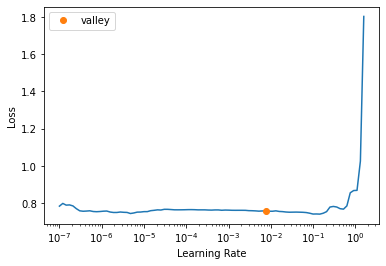

In [16]:
learner_model = text_classifier_learner(ls,   
                                  AWD_LSTM,           
                                  drop_mult = 0.5,    
                                  metrics = accuracy) 
lr = learner_model.lr_find()[0]

Имеем предложенной значение Learning rate, начнём доообучивать сеть

epoch,train_loss,valid_loss,accuracy,time
0,0.534131,0.681407,0.713022,01:24
1,0.505701,174.044662,0.775568,01:37
2,0.581683,64.033859,0.224518,01:21
3,0.458158,2.369126,0.779580,01:16
4,0.487879,50.654438,0.225381,01:17


epoch,train_loss,valid_loss,accuracy,time
0,0.527216,1.463130,0.775741,01:27
1,0.534002,0.458801,0.781952,01:36
2,0.504164,111.722855,0.230039,01:35
3,0.489250,0.528555,0.788681,01:33
4,0.525092,0.490130,0.791528,01:35


epoch,train_loss,valid_loss,accuracy,time
0,0.489898,96.859077,0.217875,01:35
1,0.497036,1.392856,0.788897,01:34
2,0.485719,0.535873,0.823448,01:34
3,0.497368,0.491150,0.781995,01:35
4,0.512410,30.659157,0.526852,01:35


epoch,train_loss,valid_loss,accuracy,time
0,0.493029,0.418199,0.802485,01:42
1,0.472690,0.408159,0.805935,01:42
2,0.489897,0.466715,0.800975,01:42
3,0.510336,0.385971,0.842212,01:44
4,0.485804,0.461196,0.805935,01:44


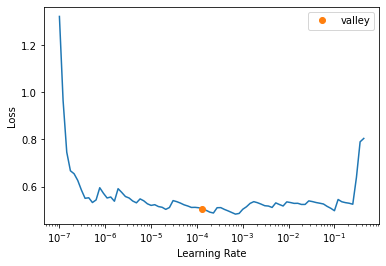

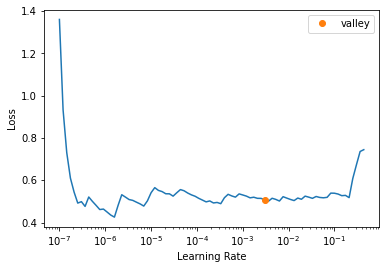

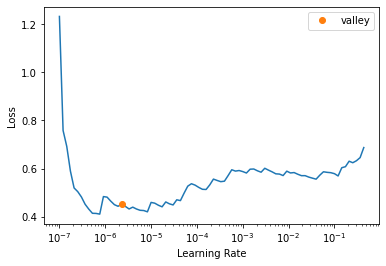

In [17]:
learner_model.freeze_to(-4) 
learner_model.fit_one_cycle(5, lr)
lr = learner_model.lr_find()[0]
learner_model.fit_one_cycle(5, lr)
lr = learner_model.lr_find()[0]
learner_model.fit_one_cycle(5, lr)
learner_model.unfreeze()
lr = learner_model.lr_find()[0]
learner_model.fit_one_cycle(5, lr)

Сохраняем полученную модель

In [19]:
learner_model.save("trained_model1")

Path('models/trained_model1.pth')

In [23]:
learner_model = learner_model.load(file = 'trained_model') # Загружаем другую, более удачную модель

Посмотрим результат на валидационной выборке

In [25]:
val_loss, val_accuracy = learner_model.validate()
print(f"""Validation loss is: {val_loss}
Validation accuracy is: {val_accuracy}""")

Validation loss is: 0.2416529655456543
Validation accuracy is: 0.9587197303771973


# __Отчёт по проведённому исследованию__
### 1. В ходе данного исследования были выявлены топ 15 банков по количеству отзывов (рис. 1). 

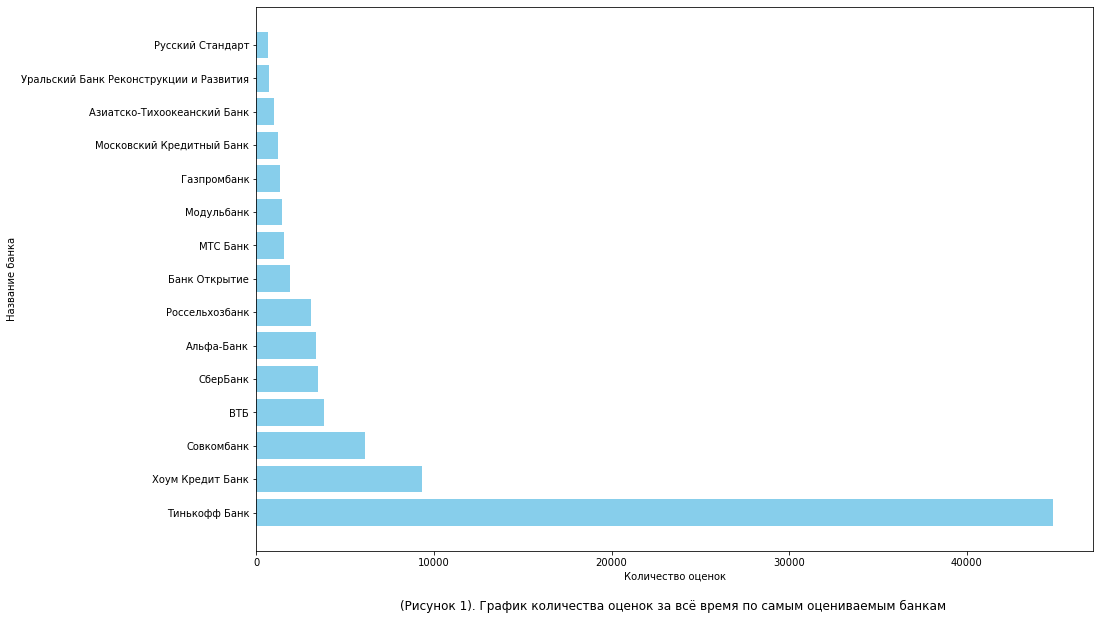

In [26]:
df_top15_review_count = pd.DataFrame(top15_review_count)
df_top15_review_count.rename(columns={"bank_name": "Was rated how many times"},inplace=True)

plt.figure(figsize=(15, 10))
plt.barh(df_top15_review_count.index, df_top15_review_count["Was rated how many times"], color='skyblue')
plt.xlabel('Количество оценок')
plt.ylabel('Название банка')
plt.title('(Рисунок 1). График количества оценок за всё время по самым оцениваемым банкам ', y=-0.12)
plt.show()

#### Как можно заметить, Тинькофф Банк обладает столь большим количеством отзывов, что даже если сложить отзывы всех остальных банков из топа, то это будет меньше чем у Тинькоффа. Причины этого феномена мне выяснить не удалось, могу сделать предположение, что на сайт banki.ru прибыли не только те, кто пользуется исключительно услугами банка, но и те, кто пользуются вторичными или другими продуктами компании Тинькофф, такими как Тинькофф Инвестиции.

### 2. Был составлен топ банков с самым высоким рейтингом и с наибольшим количеством отзывов (рис.2).

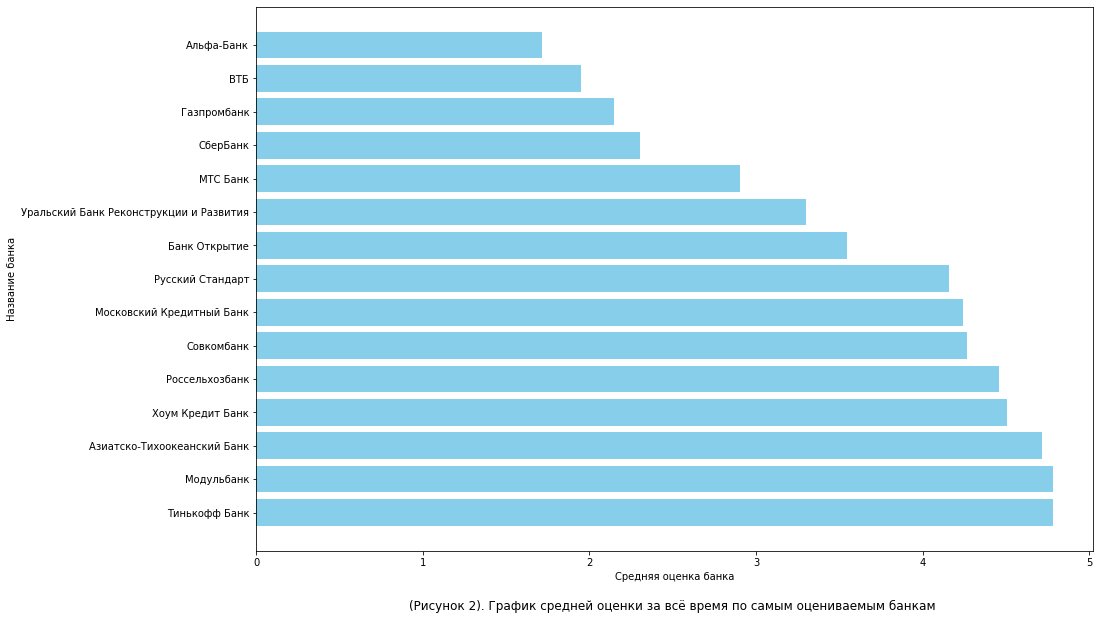

In [27]:
mask = df['bank_name'].isin(top15_review_count.index.to_numpy())
top_rated_banks = df[mask].groupby(["bank_name"])["rating"].mean().sort_values(ascending=False)[0:15]
df_top15_rating_mean = pd.DataFrame(top_rated_banks)

plt.figure(figsize=(15, 10))
plt.barh(df_top15_rating_mean.index, df_top15_rating_mean["rating"], color='skyblue')
plt.xlabel('Cредняя оценка банка')
plt.ylabel('Название банка')
plt.title('(Рисунок 2). График средней оценки за всё время по самым оцениваемым банкам ', y=-0.12)
plt.show()

#### Cамым высокооцениваемыми банками оказались Тинькофф Банк, Модульбанк и Азиатско-Тихоокеанский Банк. Если учитывать предыдущий график, то можно сделать вывод, что Тинькофф Банк обладает лучшим соотношением "Количество отзывов/Средняя оценка".

### 3. Был составлен график, отражающиий изменение средней оценки для топ-5 банков за каждый месяц (рис.3).

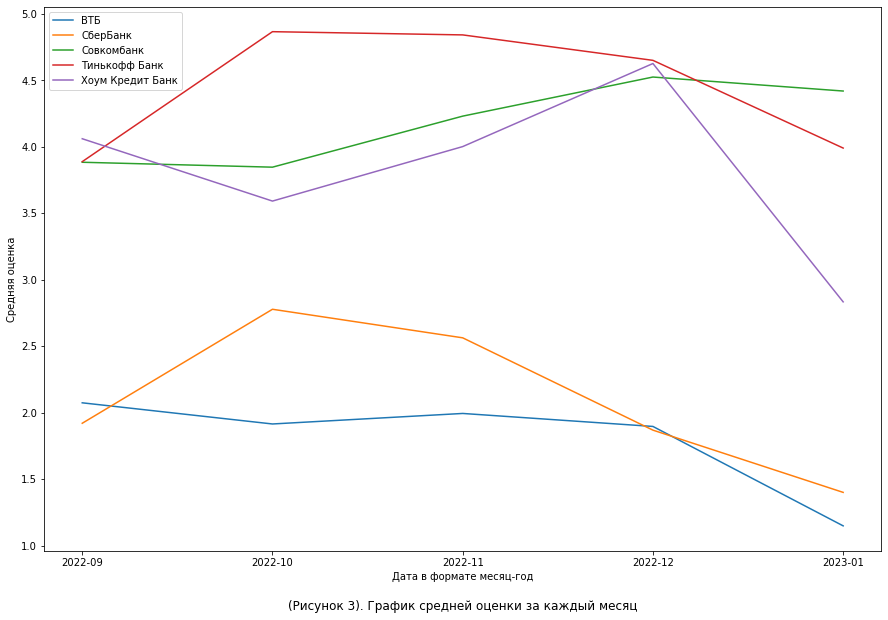

In [28]:
df_top5_mean_rate = pd.DataFrame(top5_mean_rate)

plt.figure(figsize=(15, 10))
x_axis = ["2022-09","2022-10","2022-11","2022-12","2023-01"]
plt.plot(x_axis, df_top5_mean_rate.loc["ВТБ"].to_numpy(), label='ВТБ')
plt.plot(x_axis, df_top5_mean_rate.loc["СберБанк"].to_numpy(), label='СберБанк')
plt.plot(x_axis, df_top5_mean_rate.loc["Совкомбанк"].to_numpy(), label='Совкомбанк')
plt.plot(x_axis, df_top5_mean_rate.loc["Тинькофф Банк"].to_numpy(), label='Тинькофф Банк')
plt.plot(x_axis, df_top5_mean_rate.loc["Хоум Кредит Банк"].to_numpy(), label='Хоум Кредит Банк')
plt.xlabel('Дата в формате месяц-год')
plt.ylabel('Средняя оценка')
plt.title('(Рисунок 3). График средней оценки за каждый месяц', y=-0.12)

plt.legend() 
plt.show()

#### Благодаря графику можно увидеть тендецию средней оценки каждого из пяти банков. Несмотря на уникальность кривой оценки каждого банка, можно заметить, что у Совкомбанка и Хоум Кредит Банка графики очень похожи. Так же нельзя не заметить, что у всех пяти банков к первому месяцу 2023 года просели графики среднего рейтинга, что может быть связано с особенностями системы рейтинга самого сайта banki.ru (см. ссылку https://www.banki.ru/services/responses/methodology/), которая снижает вклад отзывов, полученных давно.

### 4. Была построена модель машинного обучения, способная классифицировать отзывы на положительные и негативные

#### В качестве модели использовалась одна из тектовых моделей Fast AI, которая была дообучена на данных с сайта banki.ru. В процессе дообучения удалось достигнуть хорошего результата на валидационных данных (см. ниже).

In [30]:
val_loss, val_accuracy = learner_model.validate()
print(f"""Потеря на валидационной выборке: {val_loss}
Точность модели на валидационной выборке: {val_accuracy}""")

Потеря на валидационной выборке: 0.2416529655456543
Точность модели на валидационной выборке: 0.9587197303771973
